<a href="https://colab.research.google.com/github/areias/healthcare_fraud/blob/main/Logistic_Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [97]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from numpy import mean, std,  argmax
from sklearn.model_selection import GridSearchCV,  RandomizedSearchCV

In [3]:
final_df=pd.read_csv('Final_df.csv')
score=pd.read_csv('score.csv')

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (33,36,37) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [4]:
final_df.head()

,BeneID,DOB,DOD,Gender,Race,RenalDiseaseIndicator,State,County,NoOfMonths_PartACov,NoOfMonths_PartBCov,ChronicCond_Alzheimer,ChronicCond_Heartfailure,ChronicCond_KidneyDisease,ChronicCond_Cancer,ChronicCond_ObstrPulmonary,ChronicCond_Depression,ChronicCond_Diabetes,ChronicCond_IschemicHeart,ChronicCond_Osteoporasis,ChronicCond_rheumatoidarthritis,ChronicCond_stroke,IPAnnualReimbursementAmt,IPAnnualDeductibleAmt,OPAnnualReimbursementAmt,OPAnnualDeductibleAmt,ClaimID,ClaimStartDt,ClaimEndDt,Provider,InscClaimAmtReimbursed,AttendingPhysician,OperatingPhysician,OtherPhysician,AdmissionDt,ClmAdmitDiagnosisCode,DeductibleAmtPaid,DischargeDt,DiagnosisGroupCode,ClmDiagnosisCode_1,ClmDiagnosisCode_2,...,ClmDiagnosisCode_6,ClmDiagnosisCode_7,ClmDiagnosisCode_8,ClmDiagnosisCode_9,ClmDiagnosisCode_10,ClmProcedureCode_1,ClmProcedureCode_2,ClmProcedureCode_3,ClmProcedureCode_4,ClmProcedureCode_5,ClmProcedureCode_6,Claim_type,PotentialFraud,Age,NumberOFPhysicians,NumberOFChronic,uniqdiag,ClmAdmitDiagnosisCode_pr,ClmDiagnosisCode_1_pr,ClmDiagnosisCode_2_pr,ClmDiagnosisCode_3_pr,ClmDiagnosisCode_4_pr,ClmDiagnosisCode_5_pr,ClmDiagnosisCode_6_pr,ClmDiagnosisCode_7_pr,ClmDiagnosisCode_8_pr,ClmDiagnosisCode_9_pr,ClmDiagnosisCode_10_pr,NumOFClmDiagnosisCode,ExtraClaims,UniqProcedures,ClmProcedureCode_1_pr,ClmProcedureCode_2_pr,ClmProcedureCode_3_pr,ClmProcedureCode_4_pr,ClmProcedureCode_5_pr,ClmProcedureCode_6_pr,NumOfProcedureCode,Admit_days,DaysToProcessClaim
0,BENE11001,1943-01-01,NaN,1,1,0,39,230,12,12,1,0,1,0,0,1,1,1,0,1,1,36000,3204,60,70,CLM46614,2009-04-12,2009-04-18,PRV55912,26000,PHY390922,NaN,NaN,2009-04-12,7866,1068.0,2009-04-18,201,1970,4019,...,71590,2724,19889,5849,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Inpatient,Yes,66,1,7,10,1,1,1,1,1,1,1,1,1,1,0,10,0,0,0,0,0,0,0,0,0,6.0,6
1,BENE12511,1944-09-01,NaN,1,1,0,39,510,12,12,0,0,0,0,0,0,1,1,1,0,0,0,0,1250,90,CLM724430,2009-12-11,2009-12-11,PRV55912,600,PHY420794,NaN,NaN,NaN,NaN,0.0,NaN,NaN,V560,V4283,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes,65,1,3,2,0,1,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0.0,0
2,BENE14577,1935-10-01,NaN,2,1,Y,33,70,12,12,0,1,1,0,0,0,0,1,0,0,1,0,0,2390,440,CLM567180,2009-09-07,2009-09-07,PRV55912,20,PHY381733,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0401,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes,74,1,4,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0.0,0
3,BENE15074,1932-06-01,NaN,2,1,0,39,470,12,12,1,0,1,0,0,0,1,1,0,0,0,0,0,870,210,CLM259984,2009-03-22,2009-03-22,PRV55912,30,PHY371570,NaN,PHY393406,NaN,NaN,0.0,NaN,NaN,V812,40390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes,77,2,4,2,0,1,1,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0.0,0
4,BENE16973,1932-05-01,NaN,1,1,0,39,310,12,12,1,1,1,0,0,0,0,1,0,0,0,24000,2136,450,200,CLM565430,2009-09-06,2009-09-06,PRV55912,50,PHY365867,PHY327147,NaN,NaN,NaN,0.0,NaN,NaN,V7183,53081,...,78079,79902,25002,71848,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Outpatient,Yes,77,2,4,9,0,1,1,1,1,1,1,1,1,1,0,9,0,0,0,0,0,0,0,0,0,0.0,0


In [5]:
final_df.shape

(558211, 83)

In [6]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 558211 entries, 0 to 558210
Data columns (total 83 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   BeneID                           558211 non-null  object 
 1   DOB                              558211 non-null  object 
 2   DOD                              4131 non-null    object 
 3   Gender                           558211 non-null  int64  
 4   Race                             558211 non-null  int64  
 5   RenalDiseaseIndicator            558211 non-null  object 
 6   State                            558211 non-null  int64  
 7   County                           558211 non-null  int64  
 8   NoOfMonths_PartACov              558211 non-null  int64  
 9   NoOfMonths_PartBCov              558211 non-null  int64  
 10  ChronicCond_Alzheimer            558211 non-null  int64  
 11  ChronicCond_Heartfailure         558211 non-null  int64  
 12  Ch

## Feature Engineering:

**Number of Claims for each provider**

In [7]:
groups1 = final_df.groupby(['Provider'], as_index=False)['ClaimID'].count()
groups1

,Provider,ClaimID
0,PRV51001,25
1,PRV51003,132
2,PRV51004,149
3,PRV51005,1165
4,PRV51007,72
...,...,...
5405,PRV57759,28
5406,PRV57760,22
5407,PRV57761,82
5408,PRV57762,1


**Number of beneficiaries for each provider**

In [8]:
groups2=final_df.groupby(['Provider'], as_index=False).agg({"BeneID": "nunique"})
groups2

,Provider,BeneID
0,PRV51001,24
1,PRV51003,117
2,PRV51004,138
3,PRV51005,495
4,PRV51007,58
...,...,...
5405,PRV57759,24
5406,PRV57760,9
5407,PRV57761,67
5408,PRV57762,1


**Number of unique physicians for each provider**

In [11]:
groups3=final_df.groupby(['Provider'], as_index=False).agg({"AttendingPhysician": "nunique"})
groups3

,Provider,AttendingPhysician
0,PRV51001,14
1,PRV51003,44
2,PRV51004,38
3,PRV51005,6
4,PRV51007,10
...,...,...
5405,PRV57759,1
5406,PRV57760,3
5407,PRV57761,2
5408,PRV57762,1


**Mean number of unique physicians per claim**

Number of physicians measures the number of unique physicians for each claim (attending, operating and other) 

In [38]:
groups4=final_df.groupby(['Provider'], as_index=False)['NumberOFPhysicians'].mean()
groups4

,Provider,NumberOFPhysicians
0,PRV51001,1.280000
1,PRV51003,1.181818
2,PRV51004,1.322148
3,PRV51005,1.209442
4,PRV51007,1.125000
...,...,...
5405,PRV57759,1.000000
5406,PRV57760,1.000000
5407,PRV57761,1.182927
5408,PRV57762,1.000000


**Mean Insurance claim reimbursed**

In [12]:
groups5 = final_df.groupby(['Provider'], as_index=False)['InscClaimAmtReimbursed'].mean()
groups5

,Provider,InscClaimAmtReimbursed
0,PRV51001,4185.600000
1,PRV51003,4588.409091
2,PRV51004,350.134228
3,PRV51005,241.124464
4,PRV51007,468.194444
...,...,...
5405,PRV57759,380.000000
5406,PRV57760,216.818182
5407,PRV57761,225.243902
5408,PRV57762,1900.000000


**Mean IP deductible amount**

In [13]:
groups6=final_df.groupby(['Provider', 'BeneID'], as_index=False)['IPAnnualDeductibleAmt'].mean()
groups6=groups6.groupby(['Provider'], as_index=False)['IPAnnualDeductibleAmt'].mean()
groups6

,Provider,IPAnnualDeductibleAmt
0,PRV51001,890.000000
1,PRV51003,822.632479
2,PRV51004,454.144928
3,PRV51005,398.698990
4,PRV51007,423.517241
...,...,...
5405,PRV57759,445.000000
5406,PRV57760,237.333333
5407,PRV57761,573.850746
5408,PRV57762,1068.000000


**Mean OP deductible amount:**

In [15]:
groups7=final_df.groupby(['Provider', 'BeneID'], as_index=False)['OPAnnualDeductibleAmt'].mean()
groups7=groups7.groupby(['Provider'], as_index=False)['OPAnnualDeductibleAmt'].mean()
groups7

,Provider,OPAnnualDeductibleAmt
0,PRV51001,474.916667
1,PRV51003,664.529915
2,PRV51004,600.869565
3,PRV51005,475.965657
4,PRV51007,430.689655
...,...,...
5405,PRV57759,755.000000
5406,PRV57760,832.222222
5407,PRV57761,631.492537
5408,PRV57762,400.000000


**IP Annual Reimbursement Amt**

In [17]:
groups8=final_df.groupby(['Provider', 'BeneID'], as_index=False)['IPAnnualReimbursementAmt'].mean()
groups8=groups8.groupby(['Provider'], as_index=False)['IPAnnualReimbursementAmt'].mean()
groups8

,Provider,IPAnnualReimbursementAmt
0,PRV51001,18047.916667
1,PRV51003,6814.017094
2,PRV51004,4596.739130
3,PRV51005,3717.232323
4,PRV51007,3109.655172
...,...,...
5405,PRV57759,3414.166667
5406,PRV57760,1240.000000
5407,PRV57761,6737.313433
5408,PRV57762,15000.000000


**OP Annual Reimbursement Amt**

In [18]:
groups9=final_df.groupby(['Provider', 'BeneID'], as_index=False)['OPAnnualReimbursementAmt'].mean()
groups9=groups9.groupby(['Provider'], as_index=False)['OPAnnualReimbursementAmt'].mean()
groups9

,Provider,OPAnnualReimbursementAmt
0,PRV51001,2537.500000
1,PRV51003,2490.598291
2,PRV51004,2095.144928
3,PRV51005,1798.808081
4,PRV51007,1497.241379
...,...,...
5405,PRV57759,2910.416667
5406,PRV57760,1883.333333
5407,PRV57761,2506.716418
5408,PRV57762,2540.000000


**Beneficiaries' age**

In [20]:
groups10=final_df.groupby(['Provider', 'BeneID'], as_index=False)['Age'].mean()
groups10=groups10.groupby(['Provider'], as_index=False)['Age'].mean()
groups10

,Provider,Age
0,PRV51001,78.125000
1,PRV51003,68.957265
2,PRV51004,72.478261
3,PRV51005,69.985859
4,PRV51007,67.982759
...,...,...
5405,PRV57759,74.458333
5406,PRV57760,65.111111
5407,PRV57761,74.089552
5408,PRV57762,67.000000


**Most common county for each provider:**

In [22]:
groups11=final_df.groupby(['Provider', 'BeneID'], as_index=False)['County'].mean()
groups11=groups11.groupby(['Provider'], as_index=False)['County'].agg(pd.Series.mode)
groups11

,Provider,County
0,PRV51001,440.0
1,PRV51003,340.0
2,PRV51004,360.0
3,PRV51005,360.0
4,PRV51007,360.0
...,...,...
5405,PRV57759,120.0
5406,PRV57760,751.0
5407,PRV57761,410.0
5408,PRV57762,230.0


**Most common claim type for each provider**

In [23]:
groups12=final_df.groupby(['Provider', 'PotentialFraud'], as_index=False)['Claim_type'].agg(pd.Series.mode)
groups12

,Provider,PotentialFraud,Claim_type
0,PRV51001,No,Outpatient
1,PRV51003,Yes,Outpatient
2,PRV51004,No,Outpatient
3,PRV51005,Yes,Outpatient
4,PRV51007,No,Outpatient
...,...,...,...
5405,PRV57759,No,Outpatient
5406,PRV57760,No,Outpatient
5407,PRV57761,No,Outpatient
5408,PRV57762,No,Outpatient


**Average Claim Duration**

In [24]:
groups13 = final_df.groupby(['Provider'], as_index=False)['DaysToProcessClaim'].mean()
groups13

,Provider,DaysToProcessClaim
0,PRV51001,1.440000
1,PRV51003,3.674242
2,PRV51004,1.429530
3,PRV51005,1.088412
4,PRV51007,0.958333
...,...,...
5405,PRV57759,2.142857
5406,PRV57760,0.318182
5407,PRV57761,1.390244
5408,PRV57762,0.000000


**Average admission duration**

In [25]:
groups14 = final_df.groupby(['Provider'], as_index=False)['Admit_days'].mean()
groups14

,Provider,Admit_days
0,PRV51001,1.000000
1,PRV51003,2.424242
2,PRV51004,0.000000
3,PRV51005,0.000000
4,PRV51007,0.222222
...,...,...
5405,PRV57759,0.000000
5406,PRV57760,0.000000
5407,PRV57761,0.000000
5408,PRV57762,0.000000


**Chronic diseases**

In [34]:
Alz = final_df.loc[final_df['ChronicCond_Alzheimer']==1].groupby(['Provider'], as_index=False)['ChronicCond_Alzheimer'].count()
Alz

,Provider,ChronicCond_Alzheimer
0,PRV51001,15
1,PRV51003,56
2,PRV51004,64
3,PRV51005,426
4,PRV51007,26
...,...,...
5084,PRV57758,2
5085,PRV57759,14
5086,PRV57760,3
5087,PRV57761,36


In [27]:
Dep = final_df.loc[final_df['ChronicCond_Depression']==1].groupby(['Provider'], as_index=False)['ChronicCond_Depression'].count()
Dep

,Provider,ChronicCond_Depression
0,PRV51001,9
1,PRV51003,54
2,PRV51004,63
3,PRV51005,485
4,PRV51007,29
...,...,...
5116,PRV57757,9
5117,PRV57759,9
5118,PRV57760,7
5119,PRV57761,38


In [28]:
heart = final_df.loc[final_df['ChronicCond_Heartfailure']==1].groupby(['Provider'], as_index=False)['ChronicCond_Heartfailure'].count()
heart

,Provider,ChronicCond_Heartfailure
0,PRV51001,19
1,PRV51003,80
2,PRV51004,88
3,PRV51005,680
4,PRV51007,40
...,...,...
5249,PRV57758,2
5250,PRV57759,20
5251,PRV57760,11
5252,PRV57761,56


In [36]:
renal=final_df.loc[final_df['RenalDiseaseIndicator']=='Y'].groupby(['Provider'], as_index=False)['RenalDiseaseIndicator'].count()
renal

,Provider,RenalDiseaseIndicator
0,PRV51001,8
1,PRV51003,29
2,PRV51004,23
3,PRV51005,259
4,PRV51007,11
...,...,...
4699,PRV57756,6
4700,PRV57757,3
4701,PRV57759,5
4702,PRV57761,23


**NumberOFChronic**

In [29]:
groups15=final_df.groupby(['Provider','BeneID'], as_index=False)['NumberOFChronic'].mean() #the mean will just show the number of chronic diseases for each beneID in this case
groups15=groups15.groupby(['Provider'], as_index=False)['NumberOFChronic'].mean()
groups15

,Provider,NumberOFChronic
0,PRV51001,5.541667
1,PRV51003,4.367521
2,PRV51004,4.318841
3,PRV51005,3.884848
4,PRV51007,3.879310
...,...,...
5405,PRV57759,5.250000
5406,PRV57760,3.777778
5407,PRV57761,4.746269
5408,PRV57762,5.000000


**mean number of unique diagnosis per provider**

In [31]:
groups16=final_df.groupby(['Provider'], as_index=False)['uniqdiag'].mean() 
groups16

,Provider,uniqdiag
0,PRV51001,3.640000
1,PRV51003,5.765152
2,PRV51004,2.751678
3,PRV51005,2.786266
4,PRV51007,3.208333
...,...,...
5405,PRV57759,2.178571
5406,PRV57760,2.681818
5407,PRV57761,2.865854
5408,PRV57762,2.000000


**mean number of unique procedures per provider**

In [32]:
groups17=final_df.groupby(['Provider'], as_index=False)['UniqProcedures'].mean() 
groups17

,Provider,UniqProcedures
0,PRV51001,0.120000
1,PRV51003,0.363636
2,PRV51004,0.000000
3,PRV51005,0.000000
4,PRV51007,0.013889
...,...,...
5405,PRV57759,0.000000
5406,PRV57760,0.000000
5407,PRV57761,0.000000
5408,PRV57762,0.000000


### Merging the variables

In [73]:
from functools import reduce
pdList = [groups1, groups2, groups3, groups4, groups5, groups6, groups7, groups8, groups9, groups10, groups12, groups13,
          groups14, groups15, groups16, groups17, renal, Alz, Dep, heart]  # List of dataframes
new_df = reduce(lambda  left,right: pd.merge(left, right, how="outer" , on=['Provider']),pdList).fillna(0)

In [74]:
new_df

,Provider,ClaimID,BeneID,AttendingPhysician,NumberOFPhysicians,InscClaimAmtReimbursed,IPAnnualDeductibleAmt,OPAnnualDeductibleAmt,IPAnnualReimbursementAmt,OPAnnualReimbursementAmt,Age,PotentialFraud,Claim_type,DaysToProcessClaim,Admit_days,NumberOFChronic,uniqdiag,UniqProcedures,RenalDiseaseIndicator,ChronicCond_Alzheimer,ChronicCond_Depression,ChronicCond_Heartfailure
0,PRV51001,25,24,14,1.280000,4185.600000,890.000000,474.916667,18047.916667,2537.500000,78.125000,No,Outpatient,1.440000,1.000000,5.541667,3.640000,0.120000,8.0,15.0,9.0,19.0
1,PRV51003,132,117,44,1.181818,4588.409091,822.632479,664.529915,6814.017094,2490.598291,68.957265,Yes,Outpatient,3.674242,2.424242,4.367521,5.765152,0.363636,29.0,56.0,54.0,80.0
2,PRV51004,149,138,38,1.322148,350.134228,454.144928,600.869565,4596.739130,2095.144928,72.478261,No,Outpatient,1.429530,0.000000,4.318841,2.751678,0.000000,23.0,64.0,63.0,88.0
3,PRV51005,1165,495,6,1.209442,241.124464,398.698990,475.965657,3717.232323,1798.808081,69.985859,Yes,Outpatient,1.088412,0.000000,3.884848,2.786266,0.000000,259.0,426.0,485.0,680.0
4,PRV51007,72,58,10,1.125000,468.194444,423.517241,430.689655,3109.655172,1497.241379,67.982759,No,Outpatient,0.958333,0.222222,3.879310,3.208333,0.013889,11.0,26.0,29.0,40.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,28,24,1,1.000000,380.000000,445.000000,755.000000,3414.166667,2910.416667,74.458333,No,Outpatient,2.142857,0.000000,5.250000,2.178571,0.000000,5.0,14.0,9.0,20.0
5406,PRV57760,22,9,3,1.000000,216.818182,237.333333,832.222222,1240.000000,1883.333333,65.111111,No,Outpatient,0.318182,0.000000,3.777778,2.681818,0.000000,0.0,3.0,7.0,11.0
5407,PRV57761,82,67,2,1.182927,225.243902,573.850746,631.492537,6737.313433,2506.716418,74.089552,No,Outpatient,1.390244,0.000000,4.746269,2.865854,0.000000,23.0,36.0,38.0,56.0
5408,PRV57762,1,1,1,1.000000,1900.000000,1068.000000,400.000000,15000.000000,2540.000000,67.000000,No,Outpatient,0.000000,0.000000,5.000000,2.000000,0.000000,0.0,0.0,0.0,0.0


In [75]:
new_df['ChronicCond_Alzheimer']=new_df['ChronicCond_Alzheimer']*100/new_df['ClaimID']
new_df['ChronicCond_Depression']=new_df['ChronicCond_Depression']*100/new_df['ClaimID']
new_df['ChronicCond_Heartfailure']=new_df['ChronicCond_Heartfailure']*100/new_df['ClaimID']
new_df['RenalDiseaseIndicator']=new_df['RenalDiseaseIndicator']*100/new_df['ClaimID']

In [76]:
new_df = new_df.rename(columns={'ClaimID': 'nb_claims', 'BeneID': 'number_of_beneficiaries','AttendingPhysician':'number_of_physicians', 
                                'NumberOFPhysicians':'unique_physicians_per_claim','InscClaimAmtReimbursed': 'Avg_InscClaimAmtReimbursed', 
                                'IPAnnualDeductibleAmt':'Avg_IPAnnualDeductibleAmt', 'OPAnnualDeductibleAmt':'Avg_OPAnnualDeductibleAmt',
                                'IPAnnualReimbursementAmt':'Avg_IPAnnualReimbursementAmt', 'OPAnnualReimbursementAmt':'Avg_OPAnnualReimbursementAmt',
                                 'Claim_type': 'Most_Common_Claim_Type', 'Age': 'mean_beneficiary_age', 'County':'most_common_county',
                                'DaysToProcessClaim': 'AvgClaimDuration', 'Admit_days':'Avg_admission_days', 'NumberOFChronic':'Avg_nb_chronic',
                                'uniqdiag': 'Avg_unique_diagnosis', 'UniqProcedures':'Avg_unique_procedures', 'RenalDiseaseIndicator': 'Renal_claims_ratio',
                                'ChronicCond_Alzheimer': 'Alz_Claims_Ratio',
                                'ChronicCond_Depression': 'Dep_Claims_Ratio', 'ChronicCond_Heartfailure':'Heart_Claims_Ratio'})

In [77]:
neo_df=new_df.copy()

In [78]:
new_df=new_df.drop(['Provider'], axis=1)
new_df

,nb_claims,number_of_beneficiaries,number_of_physicians,unique_physicians_per_claim,Avg_InscClaimAmtReimbursed,Avg_IPAnnualDeductibleAmt,Avg_OPAnnualDeductibleAmt,Avg_IPAnnualReimbursementAmt,Avg_OPAnnualReimbursementAmt,mean_beneficiary_age,PotentialFraud,Most_Common_Claim_Type,AvgClaimDuration,Avg_admission_days,Avg_nb_chronic,Avg_unique_diagnosis,Avg_unique_procedures,Renal_claims_ratio,Alz_Claims_Ratio,Dep_Claims_Ratio,Heart_Claims_Ratio
0,25,24,14,1.280000,4185.600000,890.000000,474.916667,18047.916667,2537.500000,78.125000,No,Outpatient,1.440000,1.000000,5.541667,3.640000,0.120000,32.000000,60.000000,36.000000,76.000000
1,132,117,44,1.181818,4588.409091,822.632479,664.529915,6814.017094,2490.598291,68.957265,Yes,Outpatient,3.674242,2.424242,4.367521,5.765152,0.363636,21.969697,42.424242,40.909091,60.606061
2,149,138,38,1.322148,350.134228,454.144928,600.869565,4596.739130,2095.144928,72.478261,No,Outpatient,1.429530,0.000000,4.318841,2.751678,0.000000,15.436242,42.953020,42.281879,59.060403
3,1165,495,6,1.209442,241.124464,398.698990,475.965657,3717.232323,1798.808081,69.985859,Yes,Outpatient,1.088412,0.000000,3.884848,2.786266,0.000000,22.231760,36.566524,41.630901,58.369099
4,72,58,10,1.125000,468.194444,423.517241,430.689655,3109.655172,1497.241379,67.982759,No,Outpatient,0.958333,0.222222,3.879310,3.208333,0.013889,15.277778,36.111111,40.277778,55.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,28,24,1,1.000000,380.000000,445.000000,755.000000,3414.166667,2910.416667,74.458333,No,Outpatient,2.142857,0.000000,5.250000,2.178571,0.000000,17.857143,50.000000,32.142857,71.428571
5406,22,9,3,1.000000,216.818182,237.333333,832.222222,1240.000000,1883.333333,65.111111,No,Outpatient,0.318182,0.000000,3.777778,2.681818,0.000000,0.000000,13.636364,31.818182,50.000000
5407,82,67,2,1.182927,225.243902,573.850746,631.492537,6737.313433,2506.716418,74.089552,No,Outpatient,1.390244,0.000000,4.746269,2.865854,0.000000,28.048780,43.902439,46.341463,68.292683
5408,1,1,1,1.000000,1900.000000,1068.000000,400.000000,15000.000000,2540.000000,67.000000,No,Outpatient,0.000000,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [80]:
new_df['PotentialFraud'].value_counts()

No     4904
Yes     506
Name: PotentialFraud, dtype: int64

In [81]:
feature_names = list(new_df.columns.values)
feature_names.pop(-1)
labels=list(new_df.PotentialFraud.unique())

In [82]:
new_df.dtypes

nb_claims                         int64
number_of_beneficiaries           int64
number_of_physicians              int64
unique_physicians_per_claim     float64
Avg_InscClaimAmtReimbursed      float64
Avg_IPAnnualDeductibleAmt       float64
Avg_OPAnnualDeductibleAmt       float64
Avg_IPAnnualReimbursementAmt    float64
Avg_OPAnnualReimbursementAmt    float64
mean_beneficiary_age            float64
PotentialFraud                   object
Most_Common_Claim_Type           object
AvgClaimDuration                float64
Avg_admission_days              float64
Avg_nb_chronic                  float64
Avg_unique_diagnosis            float64
Avg_unique_procedures           float64
Renal_claims_ratio              float64
Alz_Claims_Ratio                float64
Dep_Claims_Ratio                float64
Heart_Claims_Ratio              float64
dtype: object

### One-hot encoding: 

In [83]:
new_df['Most_Common_Claim_Type']=new_df['Most_Common_Claim_Type'].astype('str')
new_df["Most_Common_Claim_Type"].replace({"Inpatient": 0, "Outpatient": 1, "['Inpatient' 'Outpatient']": 2}, inplace=True)

In [84]:
new_df["PotentialFraud"].replace({"No": "0", "Yes": "1"}, inplace=True)
new_df['PotentialFraud']=new_df['PotentialFraud'].astype('int')

### Splitting the data: 

In [85]:
data = new_df.drop(['PotentialFraud'], axis=1)
target = new_df['PotentialFraud']

In [86]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=15, stratify=target)

### Modeling: 

#### Logistic Regression: 

In [111]:
LG = LogisticRegression()
grid_values = {'penalty': ['l1', 'l2'],'C':[0.001,.009,0.01,.09,1,5,10,25], 'solver':['liblinear']}
grid_lg = GridSearchCV(LG, param_grid = grid_values,scoring = 'f1', cv = 5, verbose=2, n_jobs = -1)
grid_lg.fit(X_train, y_train)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.009, 0.01, 0.09, 1, 5, 10, 25],
                         'penalty': ['l1', 'l2'], 'solver': ['liblinear']},
             scoring='f1', verbose=2)

In [112]:
#Get best param: 
grid_lg.best_params_

{'C': 25, 'penalty': 'l1', 'solver': 'liblinear'}

In [113]:
log_model= grid_lg.best_estimator_

In [114]:
log_pred=log_model.predict(X_test)

In [115]:
pred_prob = log_model.predict_proba(X_test)
pred_prob

array([[0.72, 0.28],
       [0.99, 0.01],
       [0.95, 0.05],
       ...,
       [0.96, 0.04],
       [0.98, 0.02],
       [0.98, 0.02]])

In [116]:
accuracy_score(y_test, log_pred)

0.909830007390983

In [117]:
f1_score(y_test, log_pred)

0.2988505747126437

In [118]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    import itertools

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('Test states')
    plt.xlabel('Predicted states')
    plt.tight_layout()

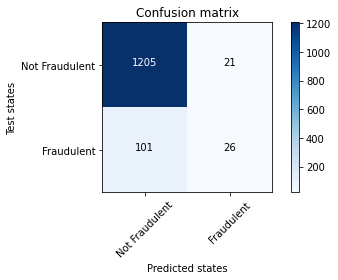

In [119]:
cnf_matrix = confusion_matrix(y_test, log_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[ 'Not Fraudulent', 'Fraudulent',],
                      title='Confusion matrix')

In [95]:
print(metrics.classification_report(y_test, log_pred))

              precision    recall  f1-score   support

           0       0.92      0.98      0.95      1226
           1       0.57      0.21      0.31       127

    accuracy                           0.91      1353
   macro avg       0.75      0.60      0.63      1353
weighted avg       0.89      0.91      0.89      1353



**ROC Curve**

In [96]:
pred_prob

array([[0.71, 0.29],
       [0.99, 0.01],
       [0.97, 0.03],
       ...,
       [0.97, 0.03],
       [0.99, 0.01],
       [0.98, 0.02]])

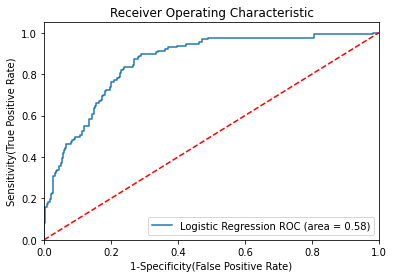

In [ ]:
##check! 
fpr, tpr, thresholds = metrics.roc_curve(y_test, pred_prob[:,1])
auc = metrics.roc_auc_score(y_test,log_pred)
plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % ('Logistic Regression', auc))
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('1-Specificity(False Positive Rate)')
plt.ylabel('Sensitivity(True Positive Rate)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()  

In [ ]:
# get the best threshold
J = tpr - fpr
ix = argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.059303


In [ ]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
	return (pos_probs >= threshold).astype('int')

probs = pred_prob[:, 1]
f1_score(y_test, to_labels(probs, best_thresh))

0.38319327731092434

#### Random Forest: 

In [122]:
from pprint import pprint
rf = RandomForestClassifier()
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
#Criterion:
criterion= ['entropy', 'auto']
# Create the random grid
rf_rand_par = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
              'criterion': criterion}
pprint(rf_rand_par)

{'bootstrap': [True, False],
 'criterion': ['entropy', 'auto'],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10],
 'n_estimators': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000]}


In [123]:
rf = RandomizedSearchCV(estimator = rf, param_distributions = rf_rand_par, n_iter = 100, cv = 3, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
159 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/pa

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['entropy', 'auto'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 120, 230, 340, 450,
                                                         560, 670, 780, 890,
                                                         1000]},
                   random_state=42, verbose=2)

In [124]:
rf.best_params_

{'bootstrap': False,
 'criterion': 'entropy',
 'max_depth': 90,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 10,
 'n_estimators': 780}

In [125]:
rf = rf.best_estimator_
rf_pred = rf.predict(X_test)

In [126]:
accuracy_score(y_test, rf_pred)

0.9320029563932003

In [127]:
f1_score(y_test, rf_pred)

0.54

In [128]:
print(metrics.classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.94      0.98      0.96      1226
           1       0.74      0.43      0.54       127

    accuracy                           0.93      1353
   macro avg       0.84      0.70      0.75      1353
weighted avg       0.92      0.93      0.92      1353



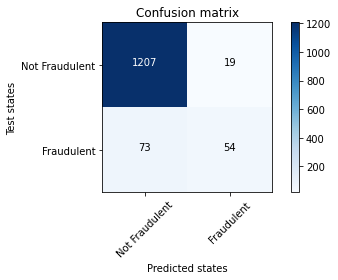

In [129]:
cnf_matrix = confusion_matrix(y_test, rf_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[ 'Not Fraudulent', 'Fraudulent'],
                      title='Confusion matrix')

#### Neo4j Model:

In [130]:
neo_df

,Provider,nb_claims,number_of_beneficiaries,number_of_physicians,unique_physicians_per_claim,Avg_InscClaimAmtReimbursed,Avg_IPAnnualDeductibleAmt,Avg_OPAnnualDeductibleAmt,Avg_IPAnnualReimbursementAmt,Avg_OPAnnualReimbursementAmt,mean_beneficiary_age,PotentialFraud,Most_Common_Claim_Type,AvgClaimDuration,Avg_admission_days,Avg_nb_chronic,Avg_unique_diagnosis,Avg_unique_procedures,Renal_claims_ratio,Alz_Claims_Ratio,Dep_Claims_Ratio,Heart_Claims_Ratio
0,PRV51001,25,24,14,1.280000,4185.600000,890.000000,474.916667,18047.916667,2537.500000,78.125000,No,Outpatient,1.440000,1.000000,5.541667,3.640000,0.120000,32.000000,60.000000,36.000000,76.000000
1,PRV51003,132,117,44,1.181818,4588.409091,822.632479,664.529915,6814.017094,2490.598291,68.957265,Yes,Outpatient,3.674242,2.424242,4.367521,5.765152,0.363636,21.969697,42.424242,40.909091,60.606061
2,PRV51004,149,138,38,1.322148,350.134228,454.144928,600.869565,4596.739130,2095.144928,72.478261,No,Outpatient,1.429530,0.000000,4.318841,2.751678,0.000000,15.436242,42.953020,42.281879,59.060403
3,PRV51005,1165,495,6,1.209442,241.124464,398.698990,475.965657,3717.232323,1798.808081,69.985859,Yes,Outpatient,1.088412,0.000000,3.884848,2.786266,0.000000,22.231760,36.566524,41.630901,58.369099
4,PRV51007,72,58,10,1.125000,468.194444,423.517241,430.689655,3109.655172,1497.241379,67.982759,No,Outpatient,0.958333,0.222222,3.879310,3.208333,0.013889,15.277778,36.111111,40.277778,55.555556
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,28,24,1,1.000000,380.000000,445.000000,755.000000,3414.166667,2910.416667,74.458333,No,Outpatient,2.142857,0.000000,5.250000,2.178571,0.000000,17.857143,50.000000,32.142857,71.428571
5406,PRV57760,22,9,3,1.000000,216.818182,237.333333,832.222222,1240.000000,1883.333333,65.111111,No,Outpatient,0.318182,0.000000,3.777778,2.681818,0.000000,0.000000,13.636364,31.818182,50.000000
5407,PRV57761,82,67,2,1.182927,225.243902,573.850746,631.492537,6737.313433,2506.716418,74.089552,No,Outpatient,1.390244,0.000000,4.746269,2.865854,0.000000,28.048780,43.902439,46.341463,68.292683
5408,PRV57762,1,1,1,1.000000,1900.000000,1068.000000,400.000000,15000.000000,2540.000000,67.000000,No,Outpatient,0.000000,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [131]:
score=score.drop(['Unnamed: 0'], axis = 1)
score

,nodeCount,max_centralityDistribution,meanscore,maxscore,componentCount,Provider,PotentialFraud
0,225,0.174390,1.231115,47.000237,4,PRV54572,No
1,20,0.420378,0.900002,6.000015,2,PRV53390,No
2,21,0.229393,0.904762,11.000000,2,PRV56999,No
3,128,0.095331,0.859376,9.000031,18,PRV51934,No
4,24,0.493816,0.916670,9.000053,2,PRV53177,No
...,...,...,...,...,...,...,...
5405,73,0.331263,0.808221,7.000023,14,PRV51387,No
5406,100,0.216396,0.780002,16.000114,22,PRV51355,No
5407,87,0.246661,1.183911,45.000122,1,PRV55322,No
5408,19,0.235690,0.947368,18.000000,1,PRV55881,No


In [132]:
final=pd.merge(neo_df, score, on=['Provider','PotentialFraud'])

In [133]:
final

,Provider,nb_claims,number_of_beneficiaries,number_of_physicians,unique_physicians_per_claim,Avg_InscClaimAmtReimbursed,Avg_IPAnnualDeductibleAmt,Avg_OPAnnualDeductibleAmt,Avg_IPAnnualReimbursementAmt,Avg_OPAnnualReimbursementAmt,mean_beneficiary_age,PotentialFraud,Most_Common_Claim_Type,AvgClaimDuration,Avg_admission_days,Avg_nb_chronic,Avg_unique_diagnosis,Avg_unique_procedures,Renal_claims_ratio,Alz_Claims_Ratio,Dep_Claims_Ratio,Heart_Claims_Ratio,nodeCount,max_centralityDistribution,meanscore,maxscore,componentCount
0,PRV51001,25,24,14,1.280000,4185.600000,890.000000,474.916667,18047.916667,2537.500000,78.125000,No,Outpatient,1.440000,1.000000,5.541667,3.640000,0.120000,32.000000,60.000000,36.000000,76.000000,42,0.352112,0.690478,7.000023,13
1,PRV51003,132,117,44,1.181818,4588.409091,822.632479,664.529915,6814.017094,2490.598291,68.957265,Yes,Outpatient,3.674242,2.424242,4.367521,5.765152,0.363636,21.969697,42.424242,40.909091,60.606061,162,0.158665,0.802471,31.000114,37
2,PRV51004,149,138,38,1.322148,350.134228,454.144928,600.869565,4596.739130,2095.144928,72.478261,No,Outpatient,1.429530,0.000000,4.318841,2.751678,0.000000,15.436242,42.953020,42.281879,59.060403,182,0.286400,0.851651,17.000114,27
3,PRV51005,1165,495,6,1.209442,241.124464,398.698990,475.965657,3717.232323,1798.808081,69.985859,Yes,Outpatient,1.088412,0.000000,3.884848,2.786266,0.000000,22.231760,36.566524,41.630901,58.369099,501,0.124846,1.770461,227.000488,1
4,PRV51007,72,58,10,1.125000,468.194444,423.517241,430.689655,3109.655172,1497.241379,67.982759,No,Outpatient,0.958333,0.222222,3.879310,3.208333,0.013889,15.277778,36.111111,40.277778,55.555556,80,0.287136,1.012503,41.000237,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5405,PRV57759,28,24,1,1.000000,380.000000,445.000000,755.000000,3414.166667,2910.416667,74.458333,No,Outpatient,2.142857,0.000000,5.250000,2.178571,0.000000,17.857143,50.000000,32.142857,71.428571,25,0.204117,0.960000,24.000000,1
5406,PRV57760,22,9,3,1.000000,216.818182,237.333333,832.222222,1240.000000,1883.333333,65.111111,No,Outpatient,0.318182,0.000000,3.777778,2.681818,0.000000,0.000000,13.636364,31.818182,50.000000,12,0.619194,1.083337,9.000053,1
5407,PRV57761,82,67,2,1.182927,225.243902,573.850746,631.492537,6737.313433,2506.716418,74.089552,No,Outpatient,1.390244,0.000000,4.746269,2.865854,0.000000,28.048780,43.902439,46.341463,68.292683,69,0.229525,1.000002,56.000183,1
5408,PRV57762,1,1,1,1.000000,1900.000000,1068.000000,400.000000,15000.000000,2540.000000,67.000000,No,Outpatient,0.000000,0.000000,5.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2,0.999046,0.500000,1.000000,1


In [134]:
final=final.drop(['Provider'], axis=1)

In [135]:
final['Most_Common_Claim_Type']=final['Most_Common_Claim_Type'].astype('str')

In [136]:
final["Most_Common_Claim_Type"].replace({"Inpatient": 0, "Outpatient": 1, "['Inpatient' 'Outpatient']": 2}, inplace=True)

In [137]:
final["Most_Common_Claim_Type"].value_counts()

1    4796
0     587
2      27
Name: Most_Common_Claim_Type, dtype: int64

In [138]:
final['Most_Common_Claim_Type']=final['Most_Common_Claim_Type'].astype('int')

In [139]:
final["PotentialFraud"].replace({"No": "0", "Yes": "1"}, inplace=True)
final['PotentialFraud']=final['PotentialFraud'].astype('int')

In [140]:
data = final.drop(['PotentialFraud'], axis=1)
target = final['PotentialFraud']

In [141]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.25, random_state=15, stratify=target)

In [142]:
X_train.shape

(4057, 25)

In [143]:
rf = RandomForestClassifier(n_estimators = 150, criterion = 'gini', random_state = 42, class_weight='balanced')
rf.fit(X_train, y_train)

RandomForestClassifier(class_weight='balanced', n_estimators=150,
                       random_state=42)

In [144]:
rf_pred = rf.predict(X_test)

In [145]:
accuracy_score(y_test, rf_pred)

0.9364375461936437

In [146]:
f1_score(y_test, rf_pred)

0.5612244897959183

In [147]:
print(metrics.classification_report(y_test, rf_pred))

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1226
           1       0.80      0.43      0.56       127

    accuracy                           0.94      1353
   macro avg       0.87      0.71      0.76      1353
weighted avg       0.93      0.94      0.93      1353



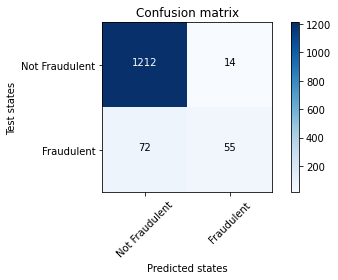

In [148]:
cnf_matrix = confusion_matrix(y_test, rf_pred)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=[ 'Not Fraudulent', 'Fraudulent'],
                      title='Confusion matrix')

In [154]:
feature_list = list(X_train.columns)
# Get numerical feature importances
importances = list(rf.feature_importances_)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances]

Variable: Avg_unique_procedures Importance: 0.13
Variable: nb_claims            Importance: 0.09
Variable: Avg_InscClaimAmtReimbursed Importance: 0.09
Variable: Avg_admission_days   Importance: 0.09
Variable: number_of_beneficiaries Importance: 0.08
Variable: nodeCount            Importance: 0.07
Variable: meanscore            Importance: 0.06
Variable: maxscore             Importance: 0.04
Variable: unique_physicians_per_claim Importance: 0.03
Variable: Avg_IPAnnualReimbursementAmt Importance: 0.03
Variable: AvgClaimDuration     Importance: 0.03
Variable: Avg_unique_diagnosis Importance: 0.03
Variable: number_of_physicians Importance: 0.02
Variable: Avg_IPAnnualDeductibleAmt Importance: 0.02
Variable: Avg_OPAnnualDeductibleAmt Importance: 0.02
Variable: Avg_OPAnnualReimbursementAmt Importance: 0.02
Variable: mean_beneficiary_age Importance: 0.02
Variable: Avg_nb_chronic       Importance: 0.02
Variable: Renal_claims_ratio   Importance: 0.02
Variable: Alz_Claims_Ratio     Importance: 0.

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

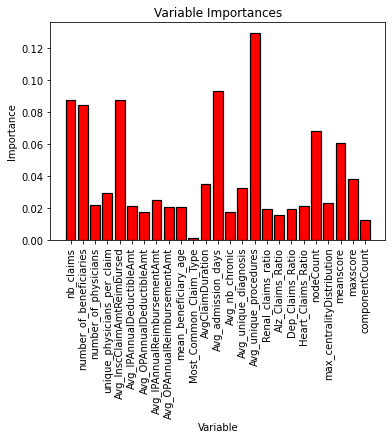

In [155]:
# list of x locations for plotting
x_values = list(range(len(importances)))
# Make a bar chart
plt.bar(x_values, importances, orientation = 'vertical', color = 'r', edgecolor = 'k', linewidth = 1.2)
# Tick labels for x axis
plt.xticks(x_values, feature_list, rotation='vertical')
# Axis labels and title
plt.ylabel('Importance'); plt.xlabel('Variable'); plt.title('Variable Importances');

In [156]:
from sklearn.ensemble import GradientBoostingClassifier
clf = GradientBoostingClassifier(n_estimators=500, learning_rate=0.01,max_depth=4, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)

0.9386548410938654

In [157]:
clf_pred = clf.predict(X_test)

In [158]:
f1_score(y_test, clf_pred)

0.6103286384976525